Credit to Hans-Petter Halvorsen and his "Mass-Spring-Damper system with Python" slides for equations and code framework

In [40]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

The following code graphs and displacement and velocity at a given time of the mass-spring-damper system. It uses the following equation: $$F(t) - c \frac{du}{dt} - kx(t) = m \frac{d^2 u}{dx^2}$$, where $t$ is the time that has passed, $F(t)$ is the external force applied to the system, $c$ is the damping constant, $k$ is the stiffness of the spring, and $m$ is the mass. 

In [3]:
tstart = 0
tstop = 60
increment = 0.1

# Initial condition
x_init = [0,0]
t = np.arange(tstart,tstop+1,increment)
F = int(input("How much force would you like to apply? "))

# Function that returns dx/dt
def mydiff(x, t):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass
    # F = 5
    dx1dt = x[1]
    dx2dt = (F - c*x[1] - k*x[0])/m
    dxdt = [dx1dt, dx2dt]
    return dxdt

How much force would you like to apply? 5


In the following lines, $x_1$ is the position $x(t)$ and $x_2$ is the velocity $\frac{dx}{dt}$

It solves the system of equations
$$\begin{cases}
    \frac{dx_1}{dt} = x_2\\
    \frac{dx_2}{dt} = \frac{1}{m}(F - cx_2 - kx_1)
\end{cases} $$

where $x = x_1$ and $\frac{dx}{dt} = x_2$

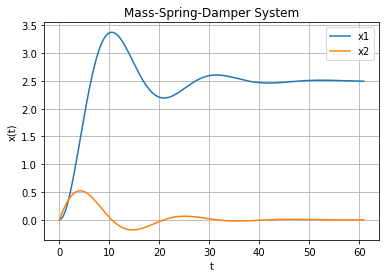

In [4]:
# Solve ODE
x = odeint(mydiff, x_init, t)
x1 = x[:,0]
x2 = x[:,1]
# Plotting results
plt.plot(t,x1)
plt.plot(t,x2)
plt.title('Mass-Spring-Damper System')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(["x1", "x2"])
plt.grid()
plt.show()

Credit to @enesdemirag and their "mass-spring-damper-system" code and explanation

In [41]:
from matplotlib import pyplot as plt
from matplotlib import animation

Taichi code:

In [2]:
import taichi as ti

[Taichi] version 1.1.2, llvm 10.0.0, commit f25cf4a2, osx, python 3.9.7
[I 09/21/22 13:03:02.329 934842] [shell.py:_shell_pop_print@33] Graphical python shell detected, using wrapped sys.stdout


using GUI interface to control a ball drawn on the screen

In [27]:
gui = ti.GUI('Title', (640, 480))
pos = np.random.random((1,2))

while gui.running:
    gui.get_event()  # must be called before is_pressed
    if gui.is_pressed('a', ti.GUI.LEFT):
        pos[0,0]-=0.01
    elif gui.is_pressed('d', ti.GUI.RIGHT):
        pos[0,0]+=0.01
    elif gui.is_pressed('w', ti.GUI.UP):
        pos[0,1]+=0.01
    elif gui.is_pressed('s', ti.GUI.DOWN):
        pos[0,1]-=0.01
    gui.circles(pos, radius=5, palette=[0x068587],palette_indices=np.array([0]))
    gui.show()


In [10]:
import taichi as ti
ti.init()

N = 8
dt = 1e-5

x = ti.Vector.field(2, dtype=ti.f32, shape=N, needs_grad=True)  # particle positions
v = ti.Vector.field(2, dtype=ti.f32, shape=N)  # particle velocities
U = ti.field(dtype=ti.f32, shape=(), needs_grad=True)  # potential energy


@ti.kernel
def compute_U():
    for i, j in ti.ndrange(N, N):
        r = x[i] - x[j]
        # r.norm(1e-3) is equivalent to ti.sqrt(r.norm()**2 + 1e-3)
        # This is to prevent 1/0 error which can cause wrong derivative
        U[None] += -1 / r.norm(1e-3)  # U += -1 / |r|


@ti.kernel
def advance():
    for i in x:
        v[i] += dt * -x.grad[i]  # dv/dt = -dU/dx
    for i in x:
        x[i] += dt * v[i]  # dx/dt = v


def substep():
    with ti.ad.Tape(loss=U):
        # Kernel invocations in this scope will later contribute to partial derivatives of
        # U with respect to input variables such as x.
        compute_U(
        )  # The tape will automatically compute dU/dx and save the results in x.grad
    advance()


@ti.kernel
def init():
    for i in x:
        x[i] = [ti.random(), ti.random()]


init()
gui = ti.GUI('Autodiff gravity')
while gui.running:
    for i in range(50):
        substep()
    gui.circles(x.to_numpy(), radius=3)
    gui.show()

[Taichi] Starting on arch=x64


In [62]:
import math

gui = ti.GUI('Spring-Mass System', (640, 480))
#pos = np.array([[0.5, 0.5]])
xpos = 0.5
ypos = 0.5
mouse_y = 0 # just a placeholder

mass = gui.slider('Mass', 5, 15, step=1)
reset = gui.button('Reset')

mass.value = 10

while gui.running:
    # gui.get_event()  # must be called before is_pressed
    for e in gui.get_events(gui.PRESS):
        if e.key == 'a':
            xpos -= 0.01
            print("moving")
        elif e.key == gui.ESCAPE:
            gui.running = False
            print("ending sim")
            exit()
        elif e.key == gui.LMB:
            xpos = gui.get_cursor_pos()[0]
        elif e.key == reset:
            xpos = 0.5
    
    gui.circle((xpos,ypos), radius=mass.value)
    gui.show()

this happened
this happened
this happened
this happened
this happened
this happened
ending sim


Now beginning the spring process. 
This one mostly focuses on the widgets and using that to control the circle

In [9]:
import math
ti.init()

dt = 1e-5

# k = spring constant
# m = mass
# c = damping constant
def calc_angular(k, m, c): 
    return math.sqrt(k/m - math.pow(c/(2*m), 2))

gui = ti.GUI('Spring-Mass System', (640, 480))
#pos = np.array([[0.5, 0.5]])
xpos = 0.5
ypos = 0.5
mouse_y = 0 # just a placeholder

mass = gui.slider('Mass', 5, 15, step=1)
damping = gui.slider('Damping', 0, 100, step=5)
spring = gui.slider('Spring Constant', 0, 1000, step=20)
reset = gui.button('Reset')

mass.value = 5
damping.value = 2
spring.value = 5

while gui.running:
    for e in gui.get_events(gui.PRESS):
        if e.key == gui.ESCAPE:
            gui.running = False
            print("ending sim")
            exit()
        elif e.key == gui.LMB: 
            # now reset it and calculate sinusoid with a new initial amplitude
            xpos = gui.get_cursor_pos()[0]
            a_0 = abs(0.5-xpos)
        elif e.key == reset:
            xpos = 0.5
    
    gui.circle((xpos,ypos), radius=mass.value)
    gui.show()

[Taichi] Starting on arch=x64


"\nx = ti.Vector.field(2, dtype=ti.f32, shape=N, needs_grad=True)  # particle positions\nv = ti.Vector.field(2, dtype=ti.f32, shape=N)  # particle velocities\nU = ti.field(dtype=ti.f32, shape=(), needs_grad=True)  # potential energy\n\n\n@ti.kernel\ndef compute_U():\n    for i, j in ti.ndrange(N, N):\n        r = x[i] - x[j]\n        # r.norm(1e-3) is equivalent to ti.sqrt(r.norm()**2 + 1e-3)\n        # This is to prevent 1/0 error which can cause wrong derivative\n        U[None] += -1 / r.norm(1e-3)  # U += -1 / |r|\n\n\n@ti.kernel\ndef advance():\n    for i in x:\n        v[i] += dt * -x.grad[i]  # dv/dt = -dU/dx\n    for i in x:\n        x[i] += dt * v[i]  # dx/dt = v\n\n\ndef substep():\n    with ti.ad.Tape(loss=U):\n        # Kernel invocations in this scope will later contribute to partial derivatives of\n        # U with respect to input variables such as x.\n        compute_U(\n        )  # The tape will automatically compute dU/dx and save the results in x.grad\n    advance()

This is a simpler version of the one above (no sliders): 

### Known bugs

Not working correctly - I believe the ti.sin function only works with matrices, and was unable to find a suitable workaround, since I only needed it for one element

In [8]:

from math import sin
import taichi as ti

ti.init()

t = 0
dt = 1e-3

# Why do i need the substeps?
substeps = 10

x = ti.field(dtype=ti.f32, shape=(2,)) # x[0] = xpos, x[1] = ypos
mass = ti.field(dtype=ti.f32, shape=())
damping = ti.field(dtype=ti.f32, shape=())
spring = ti.field(dtype=ti.f32, shape=())
base = ti.field(dtype=ti.f32, shape=(2,))
a_0 = ti.field(dtype=ti.f32, shape=())

sqrt_field = ti.field(dtype=ti.f32, shape=())


# k = spring constant
# m = mass
# c = damping constant
@ti.func
def calc_angular(k, m, c): 
    return ti.sqrt(k/m - ti.pow(c/(2*m), 2))

@ti.kernel
def substep():
    # calculate the new x position
    # d = base[0] + a_0[None] * ti.exp(-damping[None] * t/ (2 * mass[None])) * ti.cos(calc_angular(spring[None], mass[None], damping[None]) * t)
    d = base[0] + a_0[None] * ti.sin(ti.sqrt(damping[None] / mass[None]) * t)
    # redo without substep
    
    # print(d)
    
    x[0] = d
    # calculate
    

def main():
    gui = ti.GUI('Sinusoidal Motion', (640, 480))
    
    t = 0
    dt = 1e-3
    
    x[0] = 0.5
    x[1] = 0.5
    base[0] = 0.5
    base[1] = 0.5
    # initialize values
    mass[None] = 0.5
    damping[None] = 2
    spring[None] = 10
    a_0[None] = 0
    
    while gui.running:
        for e in gui.get_events(ti.GUI.PRESS):
            if e.key in [ti.GUI.ESCAPE, ti.GUI.EXIT]:
                exit()
            elif e.key == ti.GUI.LMB: #restarting sim from different spot
                # for now only simulating the sinusoidal motion in 1D
                x[0] = e.pos[0]
                a_0[None] = e.pos[0] - base[0]
                
                print("a_0 = ", a_0[None])
        
        # move stuff
        for step in range(substeps):
            substep()
            t += dt
        
        # Draw springs
        X = x.to_numpy()
        B = base.to_numpy()
        gui.line(begin=X, end=B, radius = 2, color=0x444444)
    
        gui.circle((x[0], x[1]), radius = 5)
        gui.show()
    
    
if __name__ == '__main__':
    main()



[Taichi] Starting on arch=x64
a_0 =  -0.47968751192092896
a_0 =  0.15156251192092896
a_0 =  -0.18906250596046448
a_0 =  0.13593751192092896
a_0 =  -0.1953125
a_0 =  0.1796875
a_0 =  0.004687488079071045


### Using an explicit Euler integration scheme

In [ ]:
import taichi as ti

ti.init()

spring_k = ti.field(dtype=ti.f32, shape=())
drag_damping = ti.field(dtype=ti.f32, shape=())

num_particles = 2
mass = 0.5
dt = 1e-3
substeps = 10

x = ti.Vector.field(2, dtype=ti.f32, shape=num_particles)
v = ti.Vector.field(2, dtype=ti.f32, shape=num_particles)
f = ti.Vector.field(2, dtype=ti.f32, shape=num_particles)
rest_length = ti.field(dtype=ti.f32, shape=())

@ti.kernel
def substep():
    # find force
    for i in range(num_particles):
        f[i] = [0,0] # reset force, since we're calculating it from scratch each time
        
        for j in range(num_particles):
            if i != j:
                x_ij = x[j] - x[i]
                d = x_ij.norm() # euclidean distance

                # spring force on i by j
                f[i] +=  spring_k[None] * x_ij / d * (d - rest_length[None])
                # damping force
                # f[i] += drag_damping[None] * (v[i] - v[j]) * x_ij / d
        
    for i in range(num_particles):
        # update v
        v[i] = v[i] + dt * f[i] / mass
        # update x
        x[i] = x[i] + dt * v[i]
            
            
    print(v[0], v[1])
    print(f[0], f[1])
    print("")
    

def main():
    gui = ti.GUI('Two Springs with damping', (640, 480))
    # initialize positions of particles
    x[0][0] = 0.7 # left x
    x[0][1] = 0.5 # left y
    x[1][0] = 0.3 # right x
    x[1][1] = 0.5 # right y
    v[0][0] = 0
    v[0][1] = 0
    v[1][0] = 0
    v[1][1] = 0
    
    rest_length[None] = 0.3
    spring_k[None] = 10
    drag_damping[None] = 2
    
    while gui.running:
        # Move stuff
        for step in range(substeps):
            substep()
        
        # Draw spring
        X = x.to_numpy()
        gui.line(begin=X[0], end=X[1], radius = 2, color = 0x444444)        
        # Draw particles
        for i in range(num_particles):
            gui.circle(pos=X[i], radius = 5)
        
        gui.show()
    
if __name__ == '__main__':
    main()



[Taichi] Starting on arch=x64
4982, 0.000000] [0.240531, 0.000000]
[-0.841749, 0.000000] [-1.530547, 0.000000]

[0.833282, 0.000000] [0.237476, 0.000000]
[-0.850450, 0.000000] [-1.527357, 0.000000]

[0.831563, 0.000000] [0.234428, 0.000000]
[-0.859115, 0.000000] [-1.524106, 0.000000]

[0.829828, 0.000000] [0.231386, 0.000000]
[-0.867746, 0.000000] [-1.520795, 0.000000]

[0.828075, 0.000000] [0.228351, 0.000000]
[-0.876343, 0.000000] [-1.517423, 0.000000]

[0.826305, 0.000000] [0.225323, 0.000000]
[-0.884905, 0.000000] [-1.513990, 0.000000]

[0.824518, 0.000000] [0.222302, 0.000000]
[-0.893431, 0.000000] [-1.510496, 0.000000]

[0.822715, 0.000000] [0.219289, 0.000000]
[-0.901921, 0.000000] [-1.506943, 0.000000]

[0.820894, 0.000000] [0.216282, 0.000000]
[-0.910376, 0.000000] [-1.503329, 0.000000]

[0.819056, 0.000000] [0.213283, 0.000000]
[-0.918793, 0.000000] [-1.499655, 0.000000]

[0.817202, 0.000000] [0.210291, 0.000000]
[-0.927174, 0.000000] [-1.495920, 0.000000]

[0.815331, 0.00000

[-0.033935, 0.000000] [0.033935, 0.000000]
[-0.994564, 0.000000] [0.994564, 0.000000]

[-0.035923, 0.000000] [0.035923, 0.000000]
[-0.993885, 0.000000] [0.993885, 0.000000]

[-0.037909, 0.000000] [0.037909, 0.000000]
[-0.993167, 0.000000] [0.993167, 0.000000]

[-0.039894, 0.000000] [0.039894, 0.000000]
[-0.992409, 0.000000] [0.992409, 0.000000]

[-0.041877, 0.000000] [0.041877, 0.000000]
[-0.991611, 0.000000] [0.991611, 0.000000]

[-0.043858, 0.000000] [0.043858, 0.000000]
[-0.990773, 0.000000] [0.990773, 0.000000]

[-0.045838, 0.000000] [0.045838, 0.000000]
[-0.989896, 0.000000] [0.989896, 0.000000]

[-0.047816, 0.000000] [0.047816, 0.000000]
[-0.988979, 0.000000] [0.988979, 0.000000]

[-0.049792, 0.000000] [0.049792, 0.000000]
[-0.988023, 0.000000] [0.988023, 0.000000]

[-0.051766, 0.000000] [0.051766, 0.000000]
[-0.987027, 0.000000] [0.987027, 0.000000]

[-0.053738, 0.000000] [0.053738, 0.000000]
[-0.985992, 0.000000] [0.985992, 0.000000]

[-0.055708, 0.000000] [0.055708, 0.000000]


[-0.273880, 0.000000] [0.273880, 0.000000]

[-0.304946, 0.000000] [0.304946, 0.000000]
[-0.267792, 0.000000] [0.267792, 0.000000]

[-0.305469, 0.000000] [0.305469, 0.000000]
[-0.261693, 0.000000] [0.261693, 0.000000]

[-0.305980, 0.000000] [0.305980, 0.000000]
[-0.255584, 0.000000] [0.255584, 0.000000]

[-0.306479, 0.000000] [0.306479, 0.000000]
[-0.249464, 0.000000] [0.249464, 0.000000]

[-0.306966, 0.000000] [0.306966, 0.000000]
[-0.243334, 0.000000] [0.243334, 0.000000]

[-0.307440, 0.000000] [0.307440, 0.000000]
[-0.237195, 0.000000] [0.237195, 0.000000]

[-0.307903, 0.000000] [0.307903, 0.000000]
[-0.231046, 0.000000] [0.231046, 0.000000]

[-0.308352, 0.000000] [0.308352, 0.000000]
[-0.224888, 0.000000] [0.224888, 0.000000]

[-0.308790, 0.000000] [0.308790, 0.000000]
[-0.218721, 0.000000] [0.218721, 0.000000]

[-0.309215, 0.000000] [0.309215, 0.000000]
[-0.212545, 0.000000] [0.212545, 0.000000]

[-0.309628, 0.000000] [0.309628, 0.000000]
[-0.206360, 0.000000] [0.206360, 0.000000]


[-0.191306, 0.000000] [0.191306, 0.000000]
[0.794341, 0.000000] [-0.794341, 0.000000]

[-0.189710, 0.000000] [0.189710, 0.000000]
[0.798168, 0.000000] [-0.798168, 0.000000]

[-0.188106, 0.000000] [0.188106, 0.000000]
[0.801962, 0.000000] [-0.801962, 0.000000]

[-0.186495, 0.000000] [0.186495, 0.000000]
[0.805724, 0.000000] [-0.805724, 0.000000]

[-0.184876, 0.000000] [0.184876, 0.000000]
[0.809454, 0.000000] [-0.809454, 0.000000]

[-0.183249, 0.000000] [0.183249, 0.000000]
[0.813152, 0.000000] [-0.813152, 0.000000]

[-0.181616, 0.000000] [0.181616, 0.000000]
[0.816817, 0.000000] [-0.816817, 0.000000]

[-0.179975, 0.000000] [0.179975, 0.000000]
[0.820449, 0.000000] [-0.820449, 0.000000]

[-0.178327, 0.000000] [0.178327, 0.000000]
[0.824048, 0.000000] [-0.824048, 0.000000]

[-0.176671, 0.000000] [0.176671, 0.000000]
[0.827615, 0.000000] [-0.827615, 0.000000]

[-0.175009, 0.000000] [0.175009, 0.000000]
[0.831148, 0.000000] [-0.831148, 0.000000]

[-0.173340, 0.000000] [0.173340, 0.000000]


[0.162395, 0.000000] [-0.162395, 0.000000]
[0.859690, 0.000000] [-0.859690, 0.000000]

[0.164108, 0.000000] [-0.164108, 0.000000]
[0.856442, 0.000000] [-0.856442, 0.000000]

[0.165814, 0.000000] [-0.165814, 0.000000]
[0.853160, 0.000000] [-0.853160, 0.000000]

[0.167514, 0.000000] [-0.167514, 0.000000]
[0.849843, 0.000000] [-0.849843, 0.000000]

[0.169207, 0.000000] [-0.169207, 0.000000]
[0.846493, 0.000000] [-0.846493, 0.000000]

[0.170893, 0.000000] [-0.170893, 0.000000]
[0.843109, 0.000000] [-0.843109, 0.000000]

[0.172573, 0.000000] [-0.172573, 0.000000]
[0.839691, 0.000000] [-0.839691, 0.000000]

[0.174245, 0.000000] [-0.174245, 0.000000]
[0.836240, 0.000000] [-0.836240, 0.000000]

[0.175911, 0.000000] [-0.175911, 0.000000]
[0.832755, 0.000000] [-0.832755, 0.000000]

[0.177569, 0.000000] [-0.177569, 0.000000]
[0.829237, 0.000000] [-0.829237, 0.000000]

[0.179220, 0.000000] [-0.179220, 0.000000]
[0.825686, 0.000000] [-0.825686, 0.000000]

[0.180865, 0.000000] [-0.180865, 0.000000]


[-0.153749, 0.000000] [0.153749, 0.000000]

[0.311994, 0.000000] [-0.311994, 0.000000]
[-0.159996, 0.000000] [0.159996, 0.000000]

[0.311662, 0.000000] [-0.311662, 0.000000]
[-0.166235, 0.000000] [0.166235, 0.000000]

[0.311317, 0.000000] [-0.311317, 0.000000]
[-0.172469, 0.000000] [0.172469, 0.000000]

[0.310959, 0.000000] [-0.310959, 0.000000]
[-0.178695, 0.000000] [0.178695, 0.000000]

[0.310590, 0.000000] [-0.310590, 0.000000]
[-0.184914, 0.000000] [0.184914, 0.000000]

[0.310207, 0.000000] [-0.310207, 0.000000]
[-0.191126, 0.000000] [0.191126, 0.000000]

[0.309813, 0.000000] [-0.309813, 0.000000]
[-0.197330, 0.000000] [0.197330, 0.000000]

[0.309406, 0.000000] [-0.309406, 0.000000]
[-0.203527, 0.000000] [0.203527, 0.000000]

[0.308986, 0.000000] [-0.308986, 0.000000]
[-0.209715, 0.000000] [0.209715, 0.000000]

[0.308554, 0.000000] [-0.308554, 0.000000]
[-0.215895, 0.000000] [0.215895, 0.000000]

[0.308110, 0.000000] [-0.308110, 0.000000]
[-0.222066, 0.000000] [0.222066, 0.000000]


[0.068372, 0.000000] [-0.068372, 0.000000]
[-0.975664, 0.000000] [0.975664, 0.000000]

[0.066418, 0.000000] [-0.066418, 0.000000]
[-0.977031, 0.000000] [0.977031, 0.000000]

[0.064461, 0.000000] [-0.064461, 0.000000]
[-0.978359, 0.000000] [0.978359, 0.000000]

[0.062502, 0.000000] [-0.062502, 0.000000]
[-0.979648, 0.000000] [0.979648, 0.000000]

[0.060540, 0.000000] [-0.060540, 0.000000]
[-0.980898, 0.000000] [0.980898, 0.000000]

[0.058576, 0.000000] [-0.058576, 0.000000]
[-0.982109, 0.000000] [0.982109, 0.000000]

[0.056610, 0.000000] [-0.056610, 0.000000]
[-0.983281, 0.000000] [0.983281, 0.000000]

[0.054641, 0.000000] [-0.054641, 0.000000]
[-0.984413, 0.000000] [0.984413, 0.000000]

[0.052670, 0.000000] [-0.052670, 0.000000]
[-0.985506, 0.000000] [0.985506, 0.000000]

[0.050697, 0.000000] [-0.050697, 0.000000]
[-0.986560, 0.000000] [0.986560, 0.000000]

[0.048721, 0.000000] [-0.048721, 0.000000]
[-0.987574, 0.000000] [0.987574, 0.000000]

[0.046744, 0.000000] [-0.046744, 0.000000]


[-0.261048, 0.000000] [0.261048, 0.000000]
[-0.567012, 0.000000] [0.567012, 0.000000]

[-0.262171, 0.000000] [0.262171, 0.000000]
[-0.561791, 0.000000] [0.561791, 0.000000]

[-0.263284, 0.000000] [0.263284, 0.000000]
[-0.556547, 0.000000] [0.556547, 0.000000]

[-0.264387, 0.000000] [0.264387, 0.000000]
[-0.551282, 0.000000] [0.551282, 0.000000]

[-0.265479, 0.000000] [0.265479, 0.000000]
[-0.545994, 0.000000] [0.545994, 0.000000]

[-0.266560, 0.000000] [0.266560, 0.000000]
[-0.540684, 0.000000] [0.540684, 0.000000]

[-0.267631, 0.000000] [0.267631, 0.000000]
[-0.535353, 0.000000] [0.535353, 0.000000]

[-0.268691, 0.000000] [0.268691, 0.000000]
[-0.530001, 0.000000] [0.530001, 0.000000]

[-0.269740, 0.000000] [0.269740, 0.000000]
[-0.524627, 0.000000] [0.524627, 0.000000]

[-0.270779, 0.000000] [0.270779, 0.000000]
[-0.519232, 0.000000] [0.519232, 0.000000]

[-0.271806, 0.000000] [0.271806, 0.000000]
[-0.513817, 0.000000] [0.513817, 0.000000]

[-0.272823, 0.000000] [0.272823, 0.000000]


[-0.288933, 0.000000] [0.288933, 0.000000]
[0.403544, 0.000000] [-0.403544, 0.000000]

[-0.288114, 0.000000] [0.288114, 0.000000]
[0.409322, 0.000000] [-0.409322, 0.000000]

[-0.287284, 0.000000] [0.287284, 0.000000]
[0.415085, 0.000000] [-0.415085, 0.000000]

[-0.286442, 0.000000] [0.286442, 0.000000]
[0.420831, 0.000000] [-0.420831, 0.000000]

[-0.285589, 0.000000] [0.285589, 0.000000]
[0.426559, 0.000000] [-0.426559, 0.000000]

[-0.284725, 0.000000] [0.284725, 0.000000]
[0.432271, 0.000000] [-0.432271, 0.000000]

[-0.283849, 0.000000] [0.283849, 0.000000]
[0.437966, 0.000000] [-0.437966, 0.000000]

[-0.282961, 0.000000] [0.282961, 0.000000]
[0.443642, 0.000000] [-0.443642, 0.000000]

[-0.282063, 0.000000] [0.282063, 0.000000]
[0.449302, 0.000000] [-0.449302, 0.000000]

[-0.281153, 0.000000] [0.281153, 0.000000]
[0.454943, 0.000000] [-0.454943, 0.000000]

[-0.280232, 0.000000] [0.280232, 0.000000]
[0.460566, 0.000000] [-0.460566, 0.000000]

[-0.279299, 0.000000] [0.279299, 0.000000]


[0.067114, 0.000000] [-0.067114, 0.000000]
[0.977895, 0.000000] [-0.977895, 0.000000]

[0.069067, 0.000000] [-0.069067, 0.000000]
[0.976553, 0.000000] [-0.976553, 0.000000]

[0.071017, 0.000000] [-0.071017, 0.000000]
[0.975171, 0.000000] [-0.975171, 0.000000]

[0.072965, 0.000000] [-0.072965, 0.000000]
[0.973751, 0.000000] [-0.973751, 0.000000]

[0.074909, 0.000000] [-0.074909, 0.000000]
[0.972292, 0.000000] [-0.972292, 0.000000]

[0.076851, 0.000000] [-0.076851, 0.000000]
[0.970794, 0.000000] [-0.970794, 0.000000]

[0.078789, 0.000000] [-0.078789, 0.000000]
[0.969257, 0.000000] [-0.969257, 0.000000]

[0.080725, 0.000000] [-0.080725, 0.000000]
[0.967681, 0.000000] [-0.967681, 0.000000]

[0.082657, 0.000000] [-0.082657, 0.000000]
[0.966066, 0.000000] [-0.966066, 0.000000]

[0.084586, 0.000000] [-0.084586, 0.000000]
[0.964413, 0.000000] [-0.964413, 0.000000]

[0.086511, 0.000000] [-0.086511, 0.000000]
[0.962721, 0.000000] [-0.962721, 0.000000]

[0.088433, 0.000000] [-0.088433, 0.000000]


[0.311782, 0.000000] [-0.311782, 0.000000]
[0.170251, 0.000000] [-0.170251, 0.000000]

[0.312110, 0.000000] [-0.312110, 0.000000]
[0.164016, 0.000000] [-0.164016, 0.000000]

[0.312426, 0.000000] [-0.312426, 0.000000]
[0.157773, 0.000000] [-0.157773, 0.000000]

[0.312729, 0.000000] [-0.312729, 0.000000]
[0.151525, 0.000000] [-0.151525, 0.000000]

[0.313019, 0.000000] [-0.313019, 0.000000]
[0.145270, 0.000000] [-0.145270, 0.000000]

[0.313297, 0.000000] [-0.313297, 0.000000]
[0.139010, 0.000000] [-0.139010, 0.000000]

[0.313563, 0.000000] [-0.313563, 0.000000]
[0.132744, 0.000000] [-0.132744, 0.000000]

[0.313816, 0.000000] [-0.313816, 0.000000]
[0.126472, 0.000000] [-0.126472, 0.000000]

[0.314056, 0.000000] [-0.314056, 0.000000]
[0.120196, 0.000000] [-0.120196, 0.000000]

[0.314284, 0.000000] [-0.314284, 0.000000]
[0.113915, 0.000000] [-0.113915, 0.000000]

[0.314499, 0.000000] [-0.314499, 0.000000]
[0.107629, 0.000000] [-0.107629, 0.000000]

[0.314702, 0.000000] [-0.314702, 0.000000]


[-0.851029, 0.000000] [0.851029, 0.000000]

[0.163500, 0.000000] [-0.163500, 0.000000]
[-0.854333, 0.000000] [0.854333, 0.000000]

[0.161785, 0.000000] [-0.161785, 0.000000]
[-0.857603, 0.000000] [0.857603, 0.000000]

[0.160063, 0.000000] [-0.160063, 0.000000]
[-0.860839, 0.000000] [0.860839, 0.000000]

[0.158335, 0.000000] [-0.158335, 0.000000]
[-0.864040, 0.000000] [0.864040, 0.000000]

[0.156601, 0.000000] [-0.156601, 0.000000]
[-0.867206, 0.000000] [0.867206, 0.000000]

[0.154860, 0.000000] [-0.154860, 0.000000]
[-0.870338, 0.000000] [0.870338, 0.000000]

[0.153113, 0.000000] [-0.153113, 0.000000]
[-0.873435, 0.000000] [0.873435, 0.000000]

[0.151360, 0.000000] [-0.151360, 0.000000]
[-0.876498, 0.000000] [0.876498, 0.000000]

[0.149601, 0.000000] [-0.149601, 0.000000]
[-0.879525, 0.000000] [0.879525, 0.000000]

[0.147836, 0.000000] [-0.147836, 0.000000]
[-0.882517, 0.000000] [0.882517, 0.000000]

[0.146065, 0.000000] [-0.146065, 0.000000]
[-0.885474, 0.000000] [0.885474, 0.000000]


[-0.190279, 0.000000] [0.190279, 0.000000]
[-0.800619, 0.000000] [0.800619, 0.000000]

[-0.191873, 0.000000] [0.191873, 0.000000]
[-0.796813, 0.000000] [0.796813, 0.000000]

[-0.193459, 0.000000] [0.193459, 0.000000]
[-0.792976, 0.000000] [0.792976, 0.000000]

[-0.195037, 0.000000] [0.195037, 0.000000]
[-0.789107, 0.000000] [0.789107, 0.000000]

[-0.196608, 0.000000] [0.196608, 0.000000]
[-0.785206, 0.000000] [0.785206, 0.000000]

[-0.198170, 0.000000] [0.198170, 0.000000]
[-0.781274, 0.000000] [0.781274, 0.000000]

[-0.199725, 0.000000] [0.199725, 0.000000]
[-0.777310, 0.000000] [0.777310, 0.000000]

[-0.201271, 0.000000] [0.201271, 0.000000]
[-0.773316, 0.000000] [0.773316, 0.000000]

[-0.202810, 0.000000] [0.202810, 0.000000]
[-0.769290, 0.000000] [0.769290, 0.000000]

[-0.204340, 0.000000] [0.204340, 0.000000]
[-0.765234, 0.000000] [0.765234, 0.000000]

[-0.205863, 0.000000] [0.205863, 0.000000]
[-0.761147, 0.000000] [0.761147, 0.000000]

[-0.207377, 0.000000] [0.207377, 0.000000]


[-0.305285, 0.000000] [0.305285, 0.000000]
[0.257759, 0.000000] [-0.257759, 0.000000]

[-0.304758, 0.000000] [0.304758, 0.000000]
[0.263865, 0.000000] [-0.263865, 0.000000]

[-0.304218, 0.000000] [0.304218, 0.000000]
[0.269960, 0.000000] [-0.269960, 0.000000]

[-0.303666, 0.000000] [0.303666, 0.000000]
[0.276045, 0.000000] [-0.276045, 0.000000]

[-0.303101, 0.000000] [0.303101, 0.000000]
[0.282118, 0.000000] [-0.282118, 0.000000]

[-0.302525, 0.000000] [0.302525, 0.000000]
[0.288180, 0.000000] [-0.288180, 0.000000]

[-0.301937, 0.000000] [0.301937, 0.000000]
[0.294231, 0.000000] [-0.294231, 0.000000]

[-0.301336, 0.000000] [0.301336, 0.000000]
[0.300270, 0.000000] [-0.300270, 0.000000]

[-0.300724, 0.000000] [0.300724, 0.000000]
[0.306297, 0.000000] [-0.306297, 0.000000]

[-0.300099, 0.000000] [0.300099, 0.000000]
[0.312311, 0.000000] [-0.312311, 0.000000]

[-0.299462, 0.000000] [0.299462, 0.000000]
[0.318313, 0.000000] [-0.318313, 0.000000]

[-0.298814, 0.000000] [0.298814, 0.000000]


[0.992688, 0.000000] [-0.992688, 0.000000]

[-0.035215, 0.000000] [0.035215, 0.000000]
[0.993432, 0.000000] [-0.993432, 0.000000]

[-0.033227, 0.000000] [0.033227, 0.000000]
[0.994136, 0.000000] [-0.994136, 0.000000]

[-0.031237, 0.000000] [0.031237, 0.000000]
[0.994800, 0.000000] [-0.994800, 0.000000]

[-0.029246, 0.000000] [0.029246, 0.000000]
[0.995425, 0.000000] [-0.995425, 0.000000]

[-0.027254, 0.000000] [0.027254, 0.000000]
[0.996010, 0.000000] [-0.996010, 0.000000]

[-0.025261, 0.000000] [0.025261, 0.000000]
[0.996555, 0.000000] [-0.996555, 0.000000]

[-0.023267, 0.000000] [0.023267, 0.000000]
[0.997061, 0.000000] [-0.997061, 0.000000]

[-0.021272, 0.000000] [0.021272, 0.000000]
[0.997526, 0.000000] [-0.997526, 0.000000]

[-0.019276, 0.000000] [0.019276, 0.000000]
[0.997951, 0.000000] [-0.997951, 0.000000]

[-0.017279, 0.000000] [0.017279, 0.000000]
[0.998337, 0.000000] [-0.998337, 0.000000]

[-0.015282, 0.000000] [0.015282, 0.000000]
[0.998682, 0.000000] [-0.998682, 0.000000]



[0.278518, 0.000000] [-0.278518, 0.000000]
[0.476381, 0.000000] [-0.476381, 0.000000]

[0.279460, 0.000000] [-0.279460, 0.000000]
[0.470811, 0.000000] [-0.470811, 0.000000]

[0.280390, 0.000000] [-0.280390, 0.000000]
[0.465221, 0.000000] [-0.465221, 0.000000]

[0.281309, 0.000000] [-0.281309, 0.000000]
[0.459614, 0.000000] [-0.459614, 0.000000]

[0.282217, 0.000000] [-0.282217, 0.000000]
[0.453987, 0.000000] [-0.453987, 0.000000]

[0.283114, 0.000000] [-0.283114, 0.000000]
[0.448343, 0.000000] [-0.448343, 0.000000]

[0.283999, 0.000000] [-0.283999, 0.000000]
[0.442680, 0.000000] [-0.442680, 0.000000]

[0.284873, 0.000000] [-0.284873, 0.000000]
[0.437000, 0.000000] [-0.437000, 0.000000]

[0.285736, 0.000000] [-0.285736, 0.000000]
[0.431303, 0.000000] [-0.431303, 0.000000]

[0.286587, 0.000000] [-0.286587, 0.000000]
[0.425588, 0.000000] [-0.425588, 0.000000]

[0.287427, 0.000000] [-0.287427, 0.000000]
[0.419856, 0.000000] [-0.419856, 0.000000]

[0.288255, 0.000000] [-0.288255, 0.000000]

[0.242750, 0.000000] [-0.242750, 0.000000]
[-0.638461, 0.000000] [0.638461, 0.000000]

[0.241463, 0.000000] [-0.241463, 0.000000]
[-0.643316, 0.000000] [0.643316, 0.000000]

[0.240167, 0.000000] [-0.240167, 0.000000]
[-0.648145, 0.000000] [0.648145, 0.000000]

[0.238861, 0.000000] [-0.238861, 0.000000]
[-0.652948, 0.000000] [0.652948, 0.000000]

[0.237546, 0.000000] [-0.237546, 0.000000]
[-0.657725, 0.000000] [0.657725, 0.000000]

[0.236221, 0.000000] [-0.236221, 0.000000]
[-0.662476, 0.000000] [0.662476, 0.000000]

[0.234886, 0.000000] [-0.234886, 0.000000]
[-0.667200, 0.000000] [0.667200, 0.000000]

[0.233542, 0.000000] [-0.233542, 0.000000]
[-0.671898, 0.000000] [0.671898, 0.000000]

[0.232189, 0.000000] [-0.232189, 0.000000]
[-0.676569, 0.000000] [0.676569, 0.000000]

[0.230827, 0.000000] [-0.230827, 0.000000]
[-0.681212, 0.000000] [0.681212, 0.000000]

[0.229455, 0.000000] [-0.229455, 0.000000]
[-0.685829, 0.000000] [0.685829, 0.000000]

[0.228074, 0.000000] [-0.228074, 0.000000]


[-0.952125, 0.000000] [0.952125, 0.000000]

[-0.099535, 0.000000] [0.099535, 0.000000]
[-0.950172, 0.000000] [0.950172, 0.000000]

[-0.101431, 0.000000] [0.101431, 0.000000]
[-0.948181, 0.000000] [0.948181, 0.000000]

[-0.103324, 0.000000] [0.103324, 0.000000]
[-0.946153, 0.000000] [0.946153, 0.000000]

[-0.105212, 0.000000] [0.105212, 0.000000]
[-0.944086, 0.000000] [0.944086, 0.000000]

[-0.107096, 0.000000] [0.107096, 0.000000]
[-0.941982, 0.000000] [0.941982, 0.000000]

[-0.108975, 0.000000] [0.108975, 0.000000]
[-0.939840, 0.000000] [0.939840, 0.000000]

[-0.110851, 0.000000] [0.110851, 0.000000]
[-0.937661, 0.000000] [0.937661, 0.000000]

[-0.112722, 0.000000] [0.112722, 0.000000]
[-0.935443, 0.000000] [0.935443, 0.000000]

[-0.114588, 0.000000] [0.114588, 0.000000]
[-0.933189, 0.000000] [0.933189, 0.000000]

[-0.116450, 0.000000] [0.116450, 0.000000]
[-0.930898, 0.000000] [0.930898, 0.000000]

[-0.118307, 0.000000] [0.118307, 0.000000]
[-0.928569, 0.000000] [0.928569, 0.000000]


[-0.071008, 0.000000] [0.071008, 0.000000]

[-0.315631, 0.000000] [0.315631, 0.000000]
[-0.064698, 0.000000] [0.064698, 0.000000]

[-0.315748, 0.000000] [0.315748, 0.000000]
[-0.058385, 0.000000] [0.058385, 0.000000]

[-0.315852, 0.000000] [0.315852, 0.000000]
[-0.052071, 0.000000] [0.052071, 0.000000]

[-0.315944, 0.000000] [0.315944, 0.000000]
[-0.045754, 0.000000] [0.045754, 0.000000]

[-0.316022, 0.000000] [0.316022, 0.000000]
[-0.039435, 0.000000] [0.039435, 0.000000]

[-0.316089, 0.000000] [0.316089, 0.000000]
[-0.033114, 0.000000] [0.033114, 0.000000]

[-0.316142, 0.000000] [0.316142, 0.000000]
[-0.026793, 0.000000] [0.026793, 0.000000]

[-0.316183, 0.000000] [0.316183, 0.000000]
[-0.020470, 0.000000] [0.020470, 0.000000]

[-0.316211, 0.000000] [0.316211, 0.000000]
[-0.014146, 0.000000] [0.014146, 0.000000]

[-0.316227, 0.000000] [0.316227, 0.000000]
[-0.007822, 0.000000] [0.007822, 0.000000]

[-0.316230, 0.000000] [0.316230, 0.000000]
[-0.001498, 0.000000] [0.001498, 0.000000]


[-0.135655, 0.000000] [0.135655, 0.000000]
[0.901963, 0.000000] [-0.901963, 0.000000]

[-0.133846, 0.000000] [0.133846, 0.000000]
[0.904677, 0.000000] [-0.904677, 0.000000]

[-0.132031, 0.000000] [0.132031, 0.000000]
[0.907354, 0.000000] [-0.907354, 0.000000]

[-0.130211, 0.000000] [0.130211, 0.000000]
[0.909994, 0.000000] [-0.909994, 0.000000]

[-0.128386, 0.000000] [0.128386, 0.000000]
[0.912599, 0.000000] [-0.912599, 0.000000]

[-0.126556, 0.000000] [0.126556, 0.000000]
[0.915166, 0.000000] [-0.915166, 0.000000]

[-0.124720, 0.000000] [0.124720, 0.000000]
[0.917698, 0.000000] [-0.917698, 0.000000]

[-0.122880, 0.000000] [0.122880, 0.000000]
[0.920192, 0.000000] [-0.920192, 0.000000]

[-0.121035, 0.000000] [0.121035, 0.000000]
[0.922650, 0.000000] [-0.922650, 0.000000]

[-0.119184, 0.000000] [0.119184, 0.000000]
[0.925070, 0.000000] [-0.925070, 0.000000]

[-0.117330, 0.000000] [0.117330, 0.000000]
[0.927454, 0.000000] [-0.927454, 0.000000]

[-0.115470, 0.000000] [0.115470, 0.000000]


[0.736787, 0.000000] [-0.736787, 0.000000]

[0.216014, 0.000000] [-0.216014, 0.000000]
[0.732496, 0.000000] [-0.732496, 0.000000]

[0.217470, 0.000000] [-0.217470, 0.000000]
[0.728176, 0.000000] [-0.728176, 0.000000]

[0.218918, 0.000000] [-0.218918, 0.000000]
[0.723826, 0.000000] [-0.723826, 0.000000]

[0.220357, 0.000000] [-0.220357, 0.000000]
[0.719447, 0.000000] [-0.719447, 0.000000]

[0.221787, 0.000000] [-0.221787, 0.000000]
[0.715040, 0.000000] [-0.715040, 0.000000]

[0.223208, 0.000000] [-0.223208, 0.000000]
[0.710604, 0.000000] [-0.710604, 0.000000]

[0.224620, 0.000000] [-0.224620, 0.000000]
[0.706140, 0.000000] [-0.706140, 0.000000]

[0.226023, 0.000000] [-0.226023, 0.000000]
[0.701647, 0.000000] [-0.701647, 0.000000]

[0.227418, 0.000000] [-0.227418, 0.000000]
[0.697127, 0.000000] [-0.697127, 0.000000]

[0.228803, 0.000000] [-0.228803, 0.000000]
[0.692579, 0.000000] [-0.692579, 0.000000]

[0.230179, 0.000000] [-0.230179, 0.000000]
[0.688003, 0.000000] [-0.688003, 0.000000]


[-0.352951, 0.000000] [0.352951, 0.000000]

[0.294806, 0.000000] [-0.294806, 0.000000]
[-0.358861, 0.000000] [0.358861, 0.000000]

[0.294077, 0.000000] [-0.294077, 0.000000]
[-0.364757, 0.000000] [0.364757, 0.000000]

[0.293335, 0.000000] [-0.293335, 0.000000]
[-0.370639, 0.000000] [0.370639, 0.000000]

[0.292582, 0.000000] [-0.292582, 0.000000]
[-0.376506, 0.000000] [0.376506, 0.000000]

[0.291818, 0.000000] [-0.291818, 0.000000]
[-0.382358, 0.000000] [0.382358, 0.000000]

[0.291041, 0.000000] [-0.291041, 0.000000]
[-0.388194, 0.000000] [0.388194, 0.000000]

[0.290253, 0.000000] [-0.290253, 0.000000]
[-0.394015, 0.000000] [0.394015, 0.000000]

[0.289454, 0.000000] [-0.289454, 0.000000]
[-0.399820, 0.000000] [0.399820, 0.000000]

[0.288642, 0.000000] [-0.288642, 0.000000]
[-0.405609, 0.000000] [0.405609, 0.000000]

[0.287820, 0.000000] [-0.287820, 0.000000]
[-0.411382, 0.000000] [0.411382, 0.000000]

[0.286985, 0.000000] [-0.286985, 0.000000]
[-0.417139, 0.000000] [0.417139, 0.000000]


[0.003659, 0.000000] [-0.003659, 0.000000]
[-0.999900, 0.000000] [0.999900, 0.000000]

[0.001659, 0.000000] [-0.001659, 0.000000]
[-0.999973, 0.000000] [0.999973, 0.000000]

[-0.000341, 0.000000] [0.000341, 0.000000]
[-1.000006, 0.000000] [1.000006, 0.000000]

[-0.002341, 0.000000] [0.002341, 0.000000]
[-0.999999, 0.000000] [0.999999, 0.000000]

[-0.004341, 0.000000] [0.004341, 0.000000]
[-0.999953, 0.000000] [0.999953, 0.000000]

[-0.006341, 0.000000] [0.006341, 0.000000]
[-0.999866, 0.000000] [0.999866, 0.000000]

[-0.008341, 0.000000] [0.008341, 0.000000]
[-0.999739, 0.000000] [0.999739, 0.000000]

[-0.010340, 0.000000] [0.010340, 0.000000]
[-0.999572, 0.000000] [0.999572, 0.000000]

[-0.012338, 0.000000] [0.012338, 0.000000]
[-0.999365, 0.000000] [0.999365, 0.000000]

[-0.014337, 0.000000] [0.014337, 0.000000]
[-0.999119, 0.000000] [0.999119, 0.000000]

[-0.016334, 0.000000] [0.016334, 0.000000]
[-0.998832, 0.000000] [0.998832, 0.000000]

[-0.018331, 0.000000] [0.018331, 0.000000]


[-0.239905, 0.000000] [0.239905, 0.000000]
[-0.653914, 0.000000] [0.653914, 0.000000]

[-0.241203, 0.000000] [0.241203, 0.000000]
[-0.649116, 0.000000] [0.649116, 0.000000]

[-0.242492, 0.000000] [0.242492, 0.000000]
[-0.644292, 0.000000] [0.644292, 0.000000]

[-0.243771, 0.000000] [0.243771, 0.000000]
[-0.639442, 0.000000] [0.639442, 0.000000]

[-0.245040, 0.000000] [0.245040, 0.000000]
[-0.634567, 0.000000] [0.634567, 0.000000]

[-0.246299, 0.000000] [0.246299, 0.000000]
[-0.629666, 0.000000] [0.629666, 0.000000]

[-0.247548, 0.000000] [0.247548, 0.000000]
[-0.624740, 0.000000] [0.624740, 0.000000]

[-0.248788, 0.000000] [0.248788, 0.000000]
[-0.619789, 0.000000] [0.619789, 0.000000]

[-0.250018, 0.000000] [0.250018, 0.000000]
[-0.614814, 0.000000] [0.614814, 0.000000]

[-0.251237, 0.000000] [0.251237, 0.000000]
[-0.609813, 0.000000] [0.609813, 0.000000]

[-0.252447, 0.000000] [0.252447, 0.000000]
[-0.604788, 0.000000] [0.604788, 0.000000]

[-0.253646, 0.000000] [0.253646, 0.000000]


[0.712120, 0.000000] [-0.712120, 0.000000]

[-0.219868, 0.000000] [0.219868, 0.000000]
[0.716546, 0.000000] [-0.716546, 0.000000]

[-0.218426, 0.000000] [0.218426, 0.000000]
[0.720944, 0.000000] [-0.720944, 0.000000]

[-0.216975, 0.000000] [0.216975, 0.000000]
[0.725313, 0.000000] [-0.725313, 0.000000]

[-0.215516, 0.000000] [0.215516, 0.000000]
[0.729652, 0.000000] [-0.729652, 0.000000]

[-0.214048, 0.000000] [0.214048, 0.000000]
[0.733963, 0.000000] [-0.733963, 0.000000]

[-0.212572, 0.000000] [0.212572, 0.000000]
[0.738243, 0.000000] [-0.738243, 0.000000]

[-0.211087, 0.000000] [0.211087, 0.000000]
[0.742495, 0.000000] [-0.742495, 0.000000]

[-0.209593, 0.000000] [0.209593, 0.000000]
[0.746716, 0.000000] [-0.746716, 0.000000]

[-0.208091, 0.000000] [0.208091, 0.000000]
[0.750908, 0.000000] [-0.750908, 0.000000]

[-0.206581, 0.000000] [0.206581, 0.000000]
[0.755070, 0.000000] [-0.755070, 0.000000]

[-0.205063, 0.000000] [0.205063, 0.000000]
[0.759201, 0.000000] [-0.759201, 0.000000]


[0.129008, 0.000000] [-0.129008, 0.000000]
[0.914299, 0.000000] [-0.914299, 0.000000]

[0.130832, 0.000000] [-0.130832, 0.000000]
[0.911719, 0.000000] [-0.911719, 0.000000]

[0.132650, 0.000000] [-0.132650, 0.000000]
[0.909102, 0.000000] [-0.909102, 0.000000]

[0.134463, 0.000000] [-0.134463, 0.000000]
[0.906449, 0.000000] [-0.906449, 0.000000]

[0.136270, 0.000000] [-0.136270, 0.000000]
[0.903760, 0.000000] [-0.903760, 0.000000]

[0.138072, 0.000000] [-0.138072, 0.000000]
[0.901035, 0.000000] [-0.901035, 0.000000]

[0.139869, 0.000000] [-0.139869, 0.000000]
[0.898274, 0.000000] [-0.898274, 0.000000]

[0.141660, 0.000000] [-0.141660, 0.000000]
[0.895476, 0.000000] [-0.895476, 0.000000]

[0.143445, 0.000000] [-0.143445, 0.000000]
[0.892643, 0.000000] [-0.892643, 0.000000]

[0.145225, 0.000000] [-0.145225, 0.000000]
[0.889774, 0.000000] [-0.889774, 0.000000]

[0.146998, 0.000000] [-0.146998, 0.000000]
[0.886869, 0.000000] [-0.886869, 0.000000]

[0.148766, 0.000000] [-0.148766, 0.000000]


[-0.035268, 0.000000] [0.035268, 0.000000]

[0.315915, 0.000000] [-0.315915, 0.000000]
[-0.041588, 0.000000] [0.041588, 0.000000]

[0.315819, 0.000000] [-0.315819, 0.000000]
[-0.047906, 0.000000] [0.047906, 0.000000]

[0.315711, 0.000000] [-0.315711, 0.000000]
[-0.054223, 0.000000] [0.054223, 0.000000]

[0.315589, 0.000000] [-0.315589, 0.000000]
[-0.060537, 0.000000] [0.060537, 0.000000]

[0.315456, 0.000000] [-0.315456, 0.000000]
[-0.066849, 0.000000] [0.066849, 0.000000]

[0.315309, 0.000000] [-0.315309, 0.000000]
[-0.073158, 0.000000] [0.073158, 0.000000]

[0.315150, 0.000000] [-0.315150, 0.000000]
[-0.079464, 0.000000] [0.079464, 0.000000]

[0.314979, 0.000000] [-0.314979, 0.000000]
[-0.085767, 0.000000] [0.085767, 0.000000]

[0.314795, 0.000000] [-0.314795, 0.000000]
[-0.092066, 0.000000] [0.092066, 0.000000]

[0.314598, 0.000000] [-0.314598, 0.000000]
[-0.098362, 0.000000] [0.098362, 0.000000]

[0.314389, 0.000000] [-0.314389, 0.000000]
[-0.104654, 0.000000] [0.104654, 0.000000]


[-0.940580, 0.000000] [0.940580, 0.000000]

[0.104568, 0.000000] [-0.104568, 0.000000]
[-0.942709, 0.000000] [0.942709, 0.000000]

[0.102679, 0.000000] [-0.102679, 0.000000]
[-0.944800, 0.000000] [0.944800, 0.000000]

[0.100785, 0.000000] [-0.100785, 0.000000]
[-0.946854, 0.000000] [0.946854, 0.000000]

[0.098887, 0.000000] [-0.098887, 0.000000]
[-0.948870, 0.000000] [0.948870, 0.000000]

[0.096986, 0.000000] [-0.096986, 0.000000]
[-0.950848, 0.000000] [0.950848, 0.000000]

[0.095080, 0.000000] [-0.095080, 0.000000]
[-0.952787, 0.000000] [0.952787, 0.000000]

[0.093171, 0.000000] [-0.093171, 0.000000]
[-0.954688, 0.000000] [0.954688, 0.000000]

[0.091258, 0.000000] [-0.091258, 0.000000]
[-0.956552, 0.000000] [0.956552, 0.000000]

[0.089341, 0.000000] [-0.089341, 0.000000]
[-0.958377, 0.000000] [0.958377, 0.000000]

[0.087421, 0.000000] [-0.087421, 0.000000]
[-0.960164, 0.000000] [0.960164, 0.000000]

[0.085497, 0.000000] [-0.085497, 0.000000]
[-0.961912, 0.000000] [0.961912, 0.000000]


[-0.237997, 0.000000] [0.237997, 0.000000]
[-0.660861, 0.000000] [0.660861, 0.000000]

[-0.239309, 0.000000] [0.239309, 0.000000]
[-0.656101, 0.000000] [0.656101, 0.000000]

[-0.240612, 0.000000] [0.240612, 0.000000]
[-0.651315, 0.000000] [0.651315, 0.000000]

[-0.241905, 0.000000] [0.241905, 0.000000]
[-0.646502, 0.000000] [0.646502, 0.000000]

[-0.243188, 0.000000] [0.243188, 0.000000]
[-0.641665, 0.000000] [0.641665, 0.000000]

[-0.244462, 0.000000] [0.244462, 0.000000]
[-0.636801, 0.000000] [0.636801, 0.000000]

[-0.245726, 0.000000] [0.245726, 0.000000]
[-0.631912, 0.000000] [0.631912, 0.000000]

[-0.246980, 0.000000] [0.246980, 0.000000]
[-0.626997, 0.000000] [0.626997, 0.000000]

[-0.248224, 0.000000] [0.248224, 0.000000]
[-0.622057, 0.000000] [0.622057, 0.000000]

[-0.249458, 0.000000] [0.249458, 0.000000]
[-0.617093, 0.000000] [0.617093, 0.000000]

[-0.250682, 0.000000] [0.250682, 0.000000]
[-0.612104, 0.000000] [0.612104, 0.000000]

[-0.251896, 0.000000] [0.251896, 0.000000]


[0.450271, 0.000000] [-0.450271, 0.000000]

[-0.280998, 0.000000] [0.280998, 0.000000]
[0.455909, 0.000000] [-0.455909, 0.000000]

[-0.280075, 0.000000] [0.280075, 0.000000]
[0.461529, 0.000000] [-0.461529, 0.000000]

[-0.279141, 0.000000] [0.279141, 0.000000]
[0.467131, 0.000000] [-0.467131, 0.000000]

[-0.278196, 0.000000] [0.278196, 0.000000]
[0.472713, 0.000000] [-0.472713, 0.000000]

[-0.277239, 0.000000] [0.277239, 0.000000]
[0.478277, 0.000000] [-0.478277, 0.000000]

[-0.276271, 0.000000] [0.276271, 0.000000]
[0.483822, 0.000000] [-0.483822, 0.000000]

[-0.275293, 0.000000] [0.275293, 0.000000]
[0.489347, 0.000000] [-0.489347, 0.000000]

[-0.274303, 0.000000] [0.274303, 0.000000]
[0.494853, 0.000000] [-0.494853, 0.000000]

[-0.273302, 0.000000] [0.273302, 0.000000]
[0.500339, 0.000000] [-0.500339, 0.000000]

[-0.272291, 0.000000] [0.272291, 0.000000]
[0.505805, 0.000000] [-0.505805, 0.000000]

[-0.271268, 0.000000] [0.271268, 0.000000]
[0.511251, 0.000000] [-0.511251, 0.000000]


[0.996381, 0.000000] [-0.996381, 0.000000]

[0.029925, 0.000000] [-0.029925, 0.000000]
[0.995822, 0.000000] [-0.995822, 0.000000]

[0.031916, 0.000000] [-0.031916, 0.000000]
[0.995223, 0.000000] [-0.995223, 0.000000]

[0.033905, 0.000000] [-0.033905, 0.000000]
[0.994585, 0.000000] [-0.994585, 0.000000]

[0.035893, 0.000000] [-0.035893, 0.000000]
[0.993907, 0.000000] [-0.993907, 0.000000]

[0.037879, 0.000000] [-0.037879, 0.000000]
[0.993190, 0.000000] [-0.993190, 0.000000]

[0.039864, 0.000000] [-0.039864, 0.000000]
[0.992432, 0.000000] [-0.992432, 0.000000]

[0.041847, 0.000000] [-0.041847, 0.000000]
[0.991634, 0.000000] [-0.991634, 0.000000]

[0.043829, 0.000000] [-0.043829, 0.000000]
[0.990797, 0.000000] [-0.990797, 0.000000]

[0.045808, 0.000000] [-0.045808, 0.000000]
[0.989921, 0.000000] [-0.989921, 0.000000]

[0.047786, 0.000000] [-0.047786, 0.000000]
[0.989004, 0.000000] [-0.989004, 0.000000]

[0.049763, 0.000000] [-0.049763, 0.000000]
[0.988049, 0.000000] [-0.988049, 0.000000]


[0.303297, 0.000000] [-0.303297, 0.000000]
[0.286117, 0.000000] [-0.286117, 0.000000]

[0.303858, 0.000000] [-0.303858, 0.000000]
[0.280051, 0.000000] [-0.280051, 0.000000]

[0.304405, 0.000000] [-0.304405, 0.000000]
[0.273974, 0.000000] [-0.273974, 0.000000]

[0.304941, 0.000000] [-0.304941, 0.000000]
[0.267886, 0.000000] [-0.267886, 0.000000]

[0.305465, 0.000000] [-0.305465, 0.000000]
[0.261787, 0.000000] [-0.261787, 0.000000]

[0.305976, 0.000000] [-0.305976, 0.000000]
[0.255678, 0.000000] [-0.255678, 0.000000]

[0.306475, 0.000000] [-0.306475, 0.000000]
[0.249558, 0.000000] [-0.249558, 0.000000]

[0.306962, 0.000000] [-0.306962, 0.000000]
[0.243429, 0.000000] [-0.243429, 0.000000]

[0.307437, 0.000000] [-0.307437, 0.000000]
[0.237289, 0.000000] [-0.237289, 0.000000]

[0.307899, 0.000000] [-0.307899, 0.000000]
[0.231141, 0.000000] [-0.231141, 0.000000]

[0.308349, 0.000000] [-0.308349, 0.000000]
[0.224983, 0.000000] [-0.224983, 0.000000]

[0.308787, 0.000000] [-0.308787, 0.000000]


[0.196074, 0.000000] [-0.196074, 0.000000]
[-0.782625, 0.000000] [0.782625, 0.000000]

[0.194501, 0.000000] [-0.194501, 0.000000]
[-0.786546, 0.000000] [0.786546, 0.000000]

[0.192920, 0.000000] [-0.192920, 0.000000]
[-0.790436, 0.000000] [0.790436, 0.000000]

[0.191332, 0.000000] [-0.191332, 0.000000]
[-0.794295, 0.000000] [0.794295, 0.000000]

[0.189736, 0.000000] [-0.189736, 0.000000]
[-0.798121, 0.000000] [0.798121, 0.000000]

[0.188132, 0.000000] [-0.188132, 0.000000]
[-0.801916, 0.000000] [0.801916, 0.000000]

[0.186520, 0.000000] [-0.186520, 0.000000]
[-0.805678, 0.000000] [0.805678, 0.000000]

[0.184902, 0.000000] [-0.184902, 0.000000]
[-0.809409, 0.000000] [0.809409, 0.000000]

[0.183275, 0.000000] [-0.183275, 0.000000]
[-0.813107, 0.000000] [0.813107, 0.000000]

[0.181642, 0.000000] [-0.181642, 0.000000]
[-0.816772, 0.000000] [0.816772, 0.000000]

[0.180001, 0.000000] [-0.180001, 0.000000]
[-0.820405, 0.000000] [0.820405, 0.000000]

[0.178353, 0.000000] [-0.178353, 0.000000]


[-0.869283, 0.000000] [0.869283, 0.000000]

[-0.158926, 0.000000] [0.158926, 0.000000]
[-0.866140, 0.000000] [0.866140, 0.000000]

[-0.160652, 0.000000] [0.160652, 0.000000]
[-0.862961, 0.000000] [0.862961, 0.000000]

[-0.162371, 0.000000] [0.162371, 0.000000]
[-0.859748, 0.000000] [0.859748, 0.000000]

[-0.164084, 0.000000] [0.164084, 0.000000]
[-0.856501, 0.000000] [0.856501, 0.000000]

[-0.165791, 0.000000] [0.165791, 0.000000]
[-0.853219, 0.000000] [0.853219, 0.000000]

[-0.167490, 0.000000] [0.167490, 0.000000]
[-0.849903, 0.000000] [0.849903, 0.000000]

[-0.169184, 0.000000] [0.169184, 0.000000]
[-0.846553, 0.000000] [0.846553, 0.000000]

[-0.170870, 0.000000] [0.170870, 0.000000]
[-0.843170, 0.000000] [0.843170, 0.000000]

[-0.172549, 0.000000] [0.172549, 0.000000]
[-0.839752, 0.000000] [0.839752, 0.000000]

[-0.174222, 0.000000] [0.174222, 0.000000]
[-0.836301, 0.000000] [0.836301, 0.000000]

[-0.175888, 0.000000] [0.175888, 0.000000]
[-0.832817, 0.000000] [0.832817, 0.000000]


[-0.179953, 0.000000] [0.179953, 0.000000]

[-0.311596, 0.000000] [0.311596, 0.000000]
[-0.173728, 0.000000] [0.173728, 0.000000]

[-0.311931, 0.000000] [0.311931, 0.000000]
[-0.167496, 0.000000] [0.167496, 0.000000]

[-0.312253, 0.000000] [0.312253, 0.000000]
[-0.161257, 0.000000] [0.161257, 0.000000]

[-0.312563, 0.000000] [0.312563, 0.000000]
[-0.155012, 0.000000] [0.155012, 0.000000]

[-0.312861, 0.000000] [0.312861, 0.000000]
[-0.148761, 0.000000] [0.148761, 0.000000]

[-0.313146, 0.000000] [0.313146, 0.000000]
[-0.142504, 0.000000] [0.142504, 0.000000]

[-0.313418, 0.000000] [0.313418, 0.000000]
[-0.136241, 0.000000] [0.136241, 0.000000]

[-0.313678, 0.000000] [0.313678, 0.000000]
[-0.129972, 0.000000] [0.129972, 0.000000]

[-0.313926, 0.000000] [0.313926, 0.000000]
[-0.123699, 0.000000] [0.123699, 0.000000]

[-0.314160, 0.000000] [0.314160, 0.000000]
[-0.117420, 0.000000] [0.117420, 0.000000]

[-0.314383, 0.000000] [0.314383, 0.000000]
[-0.111137, 0.000000] [0.111137, 0.000000]


[-0.074247, 0.000000] [0.074247, 0.000000]
[0.971313, 0.000000] [-0.971313, 0.000000]

[-0.072301, 0.000000] [0.072301, 0.000000]
[0.972798, 0.000000] [-0.972798, 0.000000]

[-0.070353, 0.000000] [0.070353, 0.000000]
[0.974244, 0.000000] [-0.974244, 0.000000]

[-0.068402, 0.000000] [0.068402, 0.000000]
[0.975651, 0.000000] [-0.975651, 0.000000]

[-0.066448, 0.000000] [0.066448, 0.000000]
[0.977020, 0.000000] [-0.977020, 0.000000]

[-0.064491, 0.000000] [0.064491, 0.000000]
[0.978349, 0.000000] [-0.978349, 0.000000]

[-0.062532, 0.000000] [0.062532, 0.000000]
[0.979639, 0.000000] [-0.979639, 0.000000]

[-0.060570, 0.000000] [0.060570, 0.000000]
[0.980889, 0.000000] [-0.980889, 0.000000]

[-0.058606, 0.000000] [0.058606, 0.000000]
[0.982100, 0.000000] [-0.982100, 0.000000]

[-0.056639, 0.000000] [0.056639, 0.000000]
[0.983272, 0.000000] [-0.983272, 0.000000]

[-0.054670, 0.000000] [0.054670, 0.000000]
[0.984405, 0.000000] [-0.984405, 0.000000]

[-0.052699, 0.000000] [0.052699, 0.000000]


[0.848996, 0.000000] [-0.848996, 0.000000]

[0.169641, 0.000000] [-0.169641, 0.000000]
[0.845637, 0.000000] [-0.845637, 0.000000]

[0.171326, 0.000000] [-0.171326, 0.000000]
[0.842244, 0.000000] [-0.842244, 0.000000]

[0.173004, 0.000000] [-0.173004, 0.000000]
[0.838818, 0.000000] [-0.838818, 0.000000]

[0.174674, 0.000000] [-0.174674, 0.000000]
[0.835358, 0.000000] [-0.835358, 0.000000]

[0.176338, 0.000000] [-0.176338, 0.000000]
[0.831864, 0.000000] [-0.831864, 0.000000]

[0.177995, 0.000000] [-0.177995, 0.000000]
[0.828337, 0.000000] [-0.828337, 0.000000]

[0.179644, 0.000000] [-0.179644, 0.000000]
[0.824777, 0.000000] [-0.824777, 0.000000]

[0.181287, 0.000000] [-0.181287, 0.000000]
[0.821185, 0.000000] [-0.821185, 0.000000]

[0.182922, 0.000000] [-0.182922, 0.000000]
[0.817559, 0.000000] [-0.817559, 0.000000]

[0.184550, 0.000000] [-0.184550, 0.000000]
[0.813901, 0.000000] [-0.813901, 0.000000]

[0.186170, 0.000000] [-0.186170, 0.000000]
[0.810210, 0.000000] [-0.810210, 0.000000]


[0.265110, 0.000000] [-0.265110, 0.000000]
[-0.542499, 0.000000] [0.542499, 0.000000]

[0.264015, 0.000000] [-0.264015, 0.000000]
[-0.547802, 0.000000] [0.547802, 0.000000]

[0.262909, 0.000000] [-0.262909, 0.000000]
[-0.553082, 0.000000] [0.553082, 0.000000]

[0.261792, 0.000000] [-0.261792, 0.000000]
[-0.558340, 0.000000] [0.558340, 0.000000]

[0.260665, 0.000000] [-0.260665, 0.000000]
[-0.563576, 0.000000] [0.563576, 0.000000]

[0.259527, 0.000000] [-0.259527, 0.000000]
[-0.568789, 0.000000] [0.568789, 0.000000]

[0.258379, 0.000000] [-0.258379, 0.000000]
[-0.573979, 0.000000] [0.573979, 0.000000]

[0.257221, 0.000000] [-0.257221, 0.000000]
[-0.579147, 0.000000] [0.579147, 0.000000]

[0.256052, 0.000000] [-0.256052, 0.000000]
[-0.584291, 0.000000] [0.584291, 0.000000]

[0.254874, 0.000000] [-0.254874, 0.000000]
[-0.589412, 0.000000] [0.589412, 0.000000]

[0.253685, 0.000000] [-0.253685, 0.000000]
[-0.594510, 0.000000] [0.594510, 0.000000]

[0.252485, 0.000000] [-0.252485, 0.000000]


[-0.061208, 0.000000] [0.061208, 0.000000]
[-0.981707, 0.000000] [0.981707, 0.000000]

[-0.063169, 0.000000] [0.063169, 0.000000]
[-0.980483, 0.000000] [0.980483, 0.000000]

[-0.065128, 0.000000] [0.065128, 0.000000]
[-0.979219, 0.000000] [0.979219, 0.000000]

[-0.067084, 0.000000] [0.067084, 0.000000]
[-0.977916, 0.000000] [0.977916, 0.000000]

[-0.069037, 0.000000] [0.069037, 0.000000]
[-0.976575, 0.000000] [0.976575, 0.000000]

[-0.070987, 0.000000] [0.070987, 0.000000]
[-0.975195, 0.000000] [0.975195, 0.000000]

[-0.072935, 0.000000] [0.072935, 0.000000]
[-0.973775, 0.000000] [0.973775, 0.000000]

[-0.074879, 0.000000] [0.074879, 0.000000]
[-0.972316, 0.000000] [0.972316, 0.000000]

[-0.076821, 0.000000] [0.076821, 0.000000]
[-0.970818, 0.000000] [0.970818, 0.000000]

[-0.078759, 0.000000] [0.078759, 0.000000]
[-0.969282, 0.000000] [0.969282, 0.000000]

[-0.080695, 0.000000] [0.080695, 0.000000]
[-0.967707, 0.000000] [0.967707, 0.000000]

[-0.082627, 0.000000] [0.082627, 0.000000]


[-0.189016, 0.000000] [0.189016, 0.000000]

[-0.311084, 0.000000] [0.311084, 0.000000]
[-0.182802, 0.000000] [0.182802, 0.000000]

[-0.311438, 0.000000] [0.311438, 0.000000]
[-0.176581, 0.000000] [0.176581, 0.000000]

[-0.311778, 0.000000] [0.311778, 0.000000]
[-0.170352, 0.000000] [0.170352, 0.000000]

[-0.312107, 0.000000] [0.312107, 0.000000]
[-0.164116, 0.000000] [0.164116, 0.000000]

[-0.312422, 0.000000] [0.312422, 0.000000]
[-0.157874, 0.000000] [0.157874, 0.000000]

[-0.312726, 0.000000] [0.312726, 0.000000]
[-0.151625, 0.000000] [0.151625, 0.000000]

[-0.313016, 0.000000] [0.313016, 0.000000]
[-0.145371, 0.000000] [0.145371, 0.000000]

[-0.313295, 0.000000] [0.313295, 0.000000]
[-0.139110, 0.000000] [0.139110, 0.000000]

[-0.313560, 0.000000] [0.313560, 0.000000]
[-0.132844, 0.000000] [0.132844, 0.000000]

[-0.313813, 0.000000] [0.313813, 0.000000]
[-0.126573, 0.000000] [0.126573, 0.000000]

[-0.314054, 0.000000] [0.314054, 0.000000]
[-0.120297, 0.000000] [0.120297, 0.000000]
